In [212]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

from DataManager import getTrackData, getGenreData, getFeatureData, getEchonestData

In [28]:
# Load The Data

data_location = 'fma_metadata'

genres = getGenreData()
tracks = getTrackData()

echonest = getEchonestData().echonest

In [118]:
# Calculate the Genres of Artists
#   Genres are calculated based off of the top_genre of the tracks
#   The artist genre is the most common genre that they release

artist_genres_raw = pd.concat(
    [tracks['artist']['name'], tracks['track']['genre_top']],
    axis=1, keys=['artist_name', 'genre']
)

artist_genres_raw.dropna(inplace=True)

# Get a count of all the track genres that an artist created
artist_genres = artist_genres_raw.groupby(['artist_name', 'genre'] , sort=False).size().reset_index(name='song_count')
artist_genres.sort_values(by=['artist_name', 'song_count', 'genre'], ascending=False, inplace=True)

# Get the most common genre that an artist created
indecies = artist_genres.groupby('artist_name', sort=False)['song_count'].transform(max) == artist_genres['song_count']
artist_genres = artist_genres[indecies]

artist_genres.drop(columns=['song_count'], inplace=True)
artist_genres.set_index('artist_name', inplace=True)

# Create a genre lookup table for the artists
artist_genre_lookup = artist_genres.to_dict()['genre']

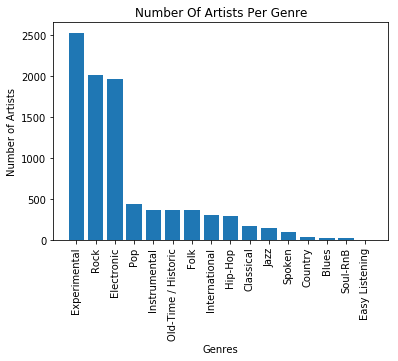

In [177]:
# Plot the number of artists in the top genres

artist_genre_counts = artist_genres['genre'].value_counts().reset_index()
artist_genre_counts.columns = ['genre', 'artist_count']

plt.bar(artist_genre_counts['genre'], artist_genre_counts['artist_count'])
plt.xticks(rotation='vertical')
plt.title('Number Of Artists Per Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Artists')
plt.show()

In [217]:
# Clean the echonest data for unsupervised training
# Note: this step reduces the dataset from 13129 to 9259 for the genre labels

echonest_features = echonest.audio_features.copy()
echonest_artist_names = echonest.metadata.artist_name

# Get the genres for all the tracks in the echonest dataset
genre_lookup = lambda artist: artist_genre_lookup[artist] if artist in artist_genre_lookup else np.nan
echonest_features['genres'] = echonest_artist_names.apply(genre_lookup)

echonest_features.dropna(inplace=True)
echonest_features = shuffle(echonest_features) # Shuffle to ensure even training

In [222]:
# Create the training and validation data sets
feature_len = len(echonest_features)
train_size = 0.8

training_data = echonest_features[training_features][0:int(feature_len * train_size)].values
validation_data = echonest_features[training_features][int(feature_len * train_size):len(echonest_features)].values

In [223]:
# Create the clustering in the echonest data set
training_features = ['acousticness', 'danceability', 'energy',
    'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence']

kmeans = KMeans(n_clusters=len(artist_genre_counts)).fit(training_data)